# Check sync process

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datetime
import pathlib
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal as sp


from u19_pipeline.ephys_pipeline import ephys_element, probe_element, get_session_directory, get_ephys_root_data_dir, BehaviorSync
# import u19_pipeline.ephys_sync as ephys
import u19_pipeline.acquisition as acquisition
import datajoint as dj

from element_interface.utils import find_full_path

import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX
import u19_pipeline.utils.ephys_utils as ephys_utils


c:\Users\MiniVR-8\miniconda3\envs\u19_pipeline_python_env\Lib\site-packages\datajoint\plugin.py:4: UserWarning: Module scripts was already imported from None, but c:\experiments\u19-pipeline-python is being added to sys.path
  import pkg_resources
[2025-11-24 13:00:18,346][INFO]: DataJoint 0.14.6 connected to u19prod@datajoint00.pni.princeton.edu:3306


In [3]:
#Behavior data
behavior = dj.create_virtual_module('behavior', 'u19_behavior')
#EphysPipeline = dj.create_virtual_module('ephys_pipeline', 'u19_ephys_pipeline')

In [4]:
def get_shift_vector(synced_time_vector, behavior_time_vector, base_size=40,initial_sample=0, samples_shift=100):


    diff_size = np.abs(synced_time_vector.shape[0] - behavior_time_vector.shape[0])

    baseline_diff = synced_time_vector[initial_sample:base_size] - behavior_time_vector[initial_sample:base_size] 

    while(1):

        base_greater = np.where(baseline_diff >0)
        base_greater = base_greater[0]

        if base_greater.shape[0] > 0 and synced_time_vector.shape[0] < behavior_time_vector.shape[0]:
            idx_first = base_greater[0]
            time_bef = behavior_time_vector[idx_first] - behavior_time_vector[idx_first-1]


            #print('idx_first', idx_first)
            #print('time_bef', time_bef)
            #print('synced_time_vector', synced_time_vector[idx_first-2:idx_first+2])
            #print('behavior_time_vector', behavior_time_vector[idx_first-2:idx_first+2])

            synced_time_vector = np.insert(synced_time_vector, idx_first, synced_time_vector[idx_first-1]+time_bef)

            #print('synced_time_vector', synced_time_vector[idx_first-2:idx_first+2])

            baseline_diff = synced_time_vector[initial_sample:base_size] - behavior_time_vector[initial_sample:base_size]
        else:
            break 


    median_diff = np.median(baseline_diff)
    max_diff = np.median(baseline_diff)+0.007
    min_diff = np.median(baseline_diff)-0.007


    vec_shift = np.zeros((synced_time_vector.shape[0]-base_size), dtype=int)
    for i in range(synced_time_vector.shape[0]-base_size):


        idx_start = initial_sample+i+1
        idx_end = base_size+i+1

        this_bt = behavior_time_vector[idx_start:idx_end]
        this_iv = synced_time_vector[idx_start:idx_end]

        median_ori = np.median(this_iv-this_bt)

        if median_ori >= min_diff and median_ori < max_diff:
            vec_shift[i] = 0
            sign = 0
        elif median_ori < min_diff:
            sign = 1
        else:
            sign = -1
            
        new_sign = sign
        if sign != 0:

            for j in range(1, samples_shift):

                if new_sign == 1:
                    if idx_end+j > synced_time_vector.shape[0]:
                        this_iv = synced_time_vector[idx_start+j:]
                        this_bt = this_bt[:-1]
                    else:
                        this_iv = synced_time_vector[idx_start+j:idx_end+j]
                else:
                    this_iv = synced_time_vector[idx_start-j:idx_end-j]
                
                median_now = np.median(this_iv-this_bt)
                
                if median_now >= min_diff and median_now < max_diff:
                    vec_shift[i] = j*new_sign
                    break
                elif median_now < min_diff:
                    new_sign = 1
                else:
                    new_sign = -1

                if new_sign != sign:
                    if np.abs(median_ori-median_diff) < np.abs(median_now-median_diff):
                        vec_shift[i] = 0
                    else:
                        vec_shift[i] = j*sign                
                    break
                    
                if j == samples_shift-1:
                    #print('Extreme case !!!')
                    vec_shift[i] = j*sign

    new_synced_time_vector = synced_time_vector.copy()
    mid_point = int(initial_sample+base_size/2)
    for i in range(vec_shift.shape[0]):
        new_synced_time_vector[mid_point+i] = synced_time_vector[mid_point+i+vec_shift[i]]
    
    idx_end = mid_point+vec_shift.shape[0]-1
    for i in range(idx_end, new_synced_time_vector.shape[0]):
        if i+vec_shift[-1] < new_synced_time_vector.shape[0]:
            new_synced_time_vector[i] = synced_time_vector[i+vec_shift[-1]]

    max_shift = np.max(np.abs(vec_shift))

    if max_shift > diff_size and diff_size != 1:
        print('max_shift', max_shift)
        print('diff_size', diff_size)
        raise ValueError('more max shift than diff size')

    return new_synced_time_vector, vec_shift, [min_diff, median_diff, max_diff]

In [5]:
def fix_shifted_sync_vector(synced_time_vector, behavior_time_vector, vec_shift, initial_sample=0, base_size=40):

    mid_point = int(initial_sample+base_size/2)
    new_synced_time_vector = synced_time_vector.copy()

    diff_vec_shift = np.diff(vec_shift)
    where_insert_iteration = np.where(diff_vec_shift != 0)
    where_insert_iteration = where_insert_iteration[0]
    #print('where_insert_iteration', where_insert_iteration)

    find = np.full(4, 1)
    correlation_result = np.correlate(diff_vec_shift == 0, find)
    consecutive_zeros = np.flatnonzero(correlation_result == 4)

    index_shift = 0
    index_borrow_virmen = list()
    for i in range(len(where_insert_iteration)):
        stable_parts = np.where(consecutive_zeros > where_insert_iteration[index_shift])
        stable_parts = stable_parts[0]

        if stable_parts.shape[0] > 0:
            index_borrow_virmen.append([where_insert_iteration[index_shift], consecutive_zeros[stable_parts[0]]])
            next_borrow_start = np.where(where_insert_iteration > consecutive_zeros[stable_parts[0]])
            next_borrow_start = next_borrow_start[0]
            if next_borrow_start.shape[0] > 0:
                index_shift = next_borrow_start[0]
            else:
                break
        else:
            print('Extreme case diff vec shift')

            index_borrow_virmen.append([where_insert_iteration[index_shift], diff_vec_shift.shape[0]])
            print('index_borrow_virmen', index_borrow_virmen)
            break



    #print('index_borrow_virmen', index_borrow_virmen)

    #for i in range(where_insert_iteration.shape[0]):
    index_diff_e  = -1
    borrowed_indexes = list()
    for i in range(len(index_borrow_virmen)):

        if index_diff_e > index_borrow_virmen[i][0]+mid_point:
            continue

        for j in range(100):

            index_diff_s = index_borrow_virmen[i][0]+mid_point-1
            index_diff_e = index_borrow_virmen[i][1]+mid_point+1

            if j>=1:
                index_diff_s = index_diff_s-1
            if j >1:
                index_diff_e = index_diff_e+j-1

            #print('index_diff_vec', index_diff_s, index_diff_e)
            #print('diff_vec_shift[index_diff] ', diff_vec_shift[index_diff_vec-1:index_diff_vec+1] )

            #print('behavior_time_vector', behavior_time_vector[index_diff_s-1:index_diff_e+2])
            #print('new_synced_time_vector2', new_synced_time_vector2[index_diff_s-1:index_diff_e+2])

            time_iteration = behavior_time_vector[index_diff_s:index_diff_e+1] - behavior_time_vector[index_diff_s]
            #print('time_iteration', time_iteration)

            new_synced_time_vector[index_diff_s:index_diff_e+1] = np.repeat(new_synced_time_vector[index_diff_s], index_diff_e-index_diff_s+1) +\
                time_iteration
            
            check_diff = np.diff(new_synced_time_vector[index_diff_s:index_diff_e+2])
            idx_back_time = np.where(check_diff <= 0.0005)
            idx_back_time = idx_back_time[0]
            if idx_back_time.shape[0] == 0:
                break
        

        borrowed_indexes.append([index_diff_s,index_diff_e+1])
        #print('new_synced_time_vector2', new_synced_time_vector2[index_diff_s-1:index_diff_e+2])
        #print('diff new_synced_time_vector2', np.diff(new_synced_time_vector2[index_diff_s-1:index_diff_e+2]))
        #print('diff new_synced_time_vector2', np.diff(behavior_time_vector[index_diff_s-1:index_diff_e+2]))



    return new_synced_time_vector, borrowed_indexes




In [6]:
def fix_sync_vector_greater(sync_time_vector, behavior_time_vector):

    new_sync_time_vector = sync_time_vector.copy()

    diff_vecs = (new_sync_time_vector - behavior_time_vector[:new_sync_time_vector.shape[0]])

    idx_plus = np.where(diff_vecs > 0)
    idx_plus = idx_plus[0]

    break_points = np.where(np.diff(idx_plus) != 1)[0] + 1
    grouped_sections = np.split(idx_plus, break_points)

    borrowed_indexes = []
    for i in range(len(grouped_sections)):

        if grouped_sections[i].shape[0] > 0:

            idx_start = grouped_sections[i][0]-1
            idx_end = grouped_sections[i][-1]

            time_vector = behavior_time_vector[idx_start:idx_end+1]-behavior_time_vector[idx_start]
            new_sync_time_vector[idx_start:idx_end+1] =\
                np.repeat(new_sync_time_vector[idx_start], idx_end-idx_start+1) + time_vector
        
            borrowed_indexes.append([idx_start, idx_end])

            
    return new_sync_time_vector, borrowed_indexes


In [7]:
def complete_last_part_sync_vec(sync_time_vector, behavior_time_vector):

    new_sync_time_vector = sync_time_vector.copy()
    
    diff_size = behavior_time_vector.shape[0] - new_sync_time_vector.shape[0]

    borrowed_indexes = []
    if diff_size > 0:
        diff_size = diff_size+1

        last_part_bt = behavior_time_vector[-diff_size:]- behavior_time_vector[-diff_size]
        insert_part = np.repeat(new_sync_time_vector[-1], diff_size) + last_part_bt
        #print('last_part_bt',last_part_bt)

        #print('insert_part',insert_part)

        new_sync_time_vector = np.append(new_sync_time_vector, insert_part[1:])
        borrowed_indexes.append([behavior_time_vector.shape[0]-diff_size, behavior_time_vector.shape[0]-1])
    
    return new_sync_time_vector, borrowed_indexes
    

In [8]:
def fix_iter_vector(synced_iteration_vector, synced_time_vector, original_time_vector, nidq_sampling_rate):

    new_synced_iteration_vector = synced_iteration_vector.copy()

    ori_shape = original_time_vector.shape[0]
    new_shape = synced_time_vector.shape[0]
    diff_iter_times_idx = original_time_vector - synced_time_vector[:ori_shape]

    first_iter = synced_iteration_vector[0]
    for i in range(diff_iter_times_idx.shape[0]):
        if diff_iter_times_idx[i] != 0:
            new_synced_iteration_vector[i] = first_iter+int(synced_time_vector[i]*nidq_sampling_rate)

    if ori_shape != new_shape:
        last_iterations =  (np.round(first_iter+synced_time_vector[ori_shape:]*nidq_sampling_rate))
        new_synced_iteration_vector = np.append(new_synced_iteration_vector, last_iterations.astype(np.int64))

    return new_synced_iteration_vector

In [9]:
def get_full_vector_samples(iter_start_idx_vectors, nidq_sampling_rate, total_samples):

    framenumber_vector_samples = np.zeros(total_samples)*np.nan
    trialnumber_vector_samples = np.zeros(total_samples)*np.nan

    for i in range(len(iter_start_idx_vectors)):

        this_trial_iter_vector = iter_start_idx_vectors[i]
        if i < len(iter_start_idx_vectors)-1:
            next_trial_iter_vector = iter_start_idx_vectors[i+1]

        #Fill vector samples
        for j in range(this_trial_iter_vector.shape[0]-1):
            framenumber_vector_samples[this_trial_iter_vector[j]:this_trial_iter_vector[j+1]] = j+1

        #Last iteration # is from start of iteration to end of trial
        if i < len(iter_start_idx_vectors)-1:
            trialnumber_vector_samples[this_trial_iter_vector[0]:next_trial_iter_vector[0]] = i+1
            framenumber_vector_samples[this_trial_iter_vector[-1]:next_trial_iter_vector[0]] = this_trial_iter_vector.shape[0]
        # For last trial, lets finish it 1s after last iteration detected
        else:
            trialnumber_vector_samples[this_trial_iter_vector[0]:this_trial_iter_vector[-1]+int(nidq_sampling_rate)] = i+1
            framenumber_vector_samples[this_trial_iter_vector[-1]:this_trial_iter_vector[-1]+int(nidq_sampling_rate)] = this_trial_iter_vector.shape[0]

    return framenumber_vector_samples, trialnumber_vector_samples

In [10]:
def sync_evaluation_process2(synced_time_vector, behavior_time_vector):

    status = 1
    diff_vector = synced_time_vector - behavior_time_vector[:synced_time_vector.shape[0]]
    num_iter = diff_vector.shape[0]

    #max_diff = max(diff_vector)
    median_general = np.median(diff_vector)

    num_div= 10
    median_diff_percent = np.empty([num_div])
    median_diff_abs = np.empty([num_div])
    for j in range(num_div):
        start_iter = int(j*num_iter/num_div)
        end_iter = int((j+1)*num_iter/num_div)
        median_diff_percent[j] = (np.median(diff_vector[start_iter:end_iter])-median_general)*100/median_general
        median_diff_abs[j] = (np.median(diff_vector[start_iter:end_iter])-median_general)


    if np.max(np.abs(median_diff_abs)) < 0.005:
        pass
    else:
        status = 0
        print(median_general)
        plt.plot(median_diff_abs)

    return status
        



In [11]:
def get_iteration_intertrial_from_virmen_time(trial_pulse_signal, nidq_sampling_rate, num_behavior_trials, behavior_time_vector):

    #Get idx samples trial starts
    trial_start_idx = ephys_utils.get_idx_trial_start(trial_pulse_signal)

    iter_start_idx = []
    for i in range(num_behavior_trials):

        new_synced_iteration_vector = trial_start_idx[i]+np.int64(behavior_time_vector[i]*nidq_sampling_rate)
        iter_start_idx.append(new_synced_iteration_vector.squeeze())

    np.asarray(iter_start_idx.copy(), dtype=object)

    return trial_start_idx, iter_start_idx




In [12]:
recording_query = "recording_id >= 500"
recording = dj.create_virtual_module('recording', 'u19_recording')
recording_keys = (recording.Recording & recording_query).fetch('recording_id', as_dict=True, order_by='recording_id')


session_fields = ['subject_fullname', 'session_date', 'session_number']
session_keys = (recording.Recording.BehaviorSession & recording_query).fetch(*session_fields, as_dict=True, order_by='recording_id')


recording_keys

[{'recording_id': np.int64(500)},
 {'recording_id': np.int64(501)},
 {'recording_id': np.int64(502)},
 {'recording_id': np.int64(503)},
 {'recording_id': np.int64(504)},
 {'recording_id': np.int64(505)},
 {'recording_id': np.int64(506)},
 {'recording_id': np.int64(507)},
 {'recording_id': np.int64(508)},
 {'recording_id': np.int64(509)},
 {'recording_id': np.int64(510)},
 {'recording_id': np.int64(511)},
 {'recording_id': np.int64(512)},
 {'recording_id': np.int64(513)},
 {'recording_id': np.int64(514)},
 {'recording_id': np.int64(515)},
 {'recording_id': np.int64(516)},
 {'recording_id': np.int64(517)},
 {'recording_id': np.int64(518)},
 {'recording_id': np.int64(519)},
 {'recording_id': np.int64(520)}]

# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

### Read nidaq file and behavior data

In [16]:
trial_sync_stats = []

max_diff_virmen_vs_trad = []
min_diff_virmen_vs_trad = []
for idx_session in range(8):
    recording_key = recording_keys[idx_session]
    session_key = session_keys[idx_session]

    session_dir = find_full_path(get_ephys_root_data_dir(),
                                get_session_directory(recording_key))
    print(session_dir)
    #session_dir = pathlib.Path('/Users/alvaros/Documents/MATLAB/BrainCogsProjects/CalciumImagingData/test_g0/')
    #Check if session is Nidq or OneBox
    nidq_session = list(session_dir.glob('*nidq.bin*'))
    obx_session = list(session_dir.glob('*obx.bin*'))

    if len(nidq_session) == 0 and len(obx_session) == 0:
        print('No session found')
    elif len(nidq_session) > 0:
        ephys_session_fullpath = nidq_session[0]
    else:
        ephys_session_fullpath = obx_session[0]

    #Nidaq file
    nidq_meta          = readSGLX.readMeta(ephys_session_fullpath)
    nidq_sampling_rate = readSGLX.SampRate(nidq_meta)


    # 1: load meta data, and the content of the NIDAQ file. Its content is digital.            
    new_trial_channel = 1
    new_iteration_channel = 2
    # If PXIe card (nidq) card use for recording deduce digital channels
    if nidq_meta['typeThis'] == 'nidq':
        digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta)
    # If onebox card (obx) card use for recording digital channels are 0-2
    else:
        digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta, d_line_list=[0,1])
        # If no sync pulse found trial and iteration signals are 0 & 1 respectively
        channel0_pulses = np.where(np.diff(digital_array[0])==1)[0].shape[0]
        channel1_pulses = np.where(np.diff(digital_array[1])==1)[0].shape[0]

        if channel0_pulses > channel1_pulses:
            new_trial_channel = 1
            new_iteration_channel = 0
        else:
            new_trial_channel = 0
            new_iteration_channel = 1

    
    thissession = behavior.TowersBlock().Trial() & session_key
    behavior_time, iterstart, beh_num_iterations = thissession.fetch('trial_time', 'vi_start', 'iterations')

    mode = None   #Default for sessions before 12/01/2021
    #mode = 'pulses'    #Default for sessions after 12/01/2021
    iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(digital_array[new_trial_channel,:], digital_array[new_iteration_channel,:], nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode=mode)

    _, iteration_dict['iter_intertrial_from_virmen'] = get_iteration_intertrial_from_virmen_time(digital_array[new_trial_channel,:], nidq_sampling_rate, behavior_time.shape[0], behavior_time)

    iteration_dict['framenumber_vector_samples'], iteration_dict['trialnumber_vector_samples'] =\
        get_full_vector_samples(iteration_dict['iter_start_idx'], nidq_sampling_rate, digital_array.shape[1])
    
    iteration_dict['framenumber_vector_samples_from_virmen'], iteration_dict['trialnumber_vector_samples_from_virmen'] =\
        get_full_vector_samples(iteration_dict['iter_intertrial_from_virmen'], nidq_sampling_rate, digital_array.shape[1])

    diff_virmen_vs_trad = iteration_dict['framenumber_vector_samples_from_virmen'] - iteration_dict['framenumber_vector_samples']

    max_diff_virmen_vs_trad.append(np.nanmax(diff_virmen_vs_trad))
    min_diff_virmen_vs_trad.append(np.nanmin(diff_virmen_vs_trad))

    extreme_cases = list()
    ghost_iter = list()
    ghost_iter2 = list()
    
    for i in range(len(iteration_dict['iter_start_idx'])):

        trial_stats_dict= {}
        trial_stats_dict['num_trial'] = i+1

        #print('fixing trial ',i)
        behavior_time_vector = behavior_time[i].flatten()
        synced_time_vector, shift_vec, median_vec = get_shift_vector(iteration_dict['iter_times_idx'][i],behavior_time_vector)
        trial_stats_dict['max_shift'] = np.max(shift_vec)
        trial_stats_dict['min_shift'] = np.min(shift_vec)
        trial_stats_dict['median_diff'] = median_vec[1]
        trial_stats_dict['min_diff'] = median_vec[0]
        trial_stats_dict['max_diff'] = median_vec[2]
        
        synced_time_vector,trial_stats_dict['borrow_step2'] =\
            fix_shifted_sync_vector(synced_time_vector, behavior_time_vector, shift_vec)

        idx_ghost_iter = np.where(np.diff(synced_time_vector)<0)
        idx_ghost_iter = idx_ghost_iter[0]
        if idx_ghost_iter.shape[0] > 0:
            ghost_iter.append(i)

        synced_time_vector, trial_stats_dict['borrow_step3'] =\
            fix_sync_vector_greater(synced_time_vector, behavior_time_vector)
        synced_time_vector, trial_stats_dict['borrow_step4'] =\
            complete_last_part_sync_vec(synced_time_vector, behavior_time_vector)

        idx_ghost_iter = np.where(np.diff(synced_time_vector)<=0)
        idx_ghost_iter = idx_ghost_iter[0]
        if idx_ghost_iter.shape[0] > 0:
            ghost_iter2.append(i)

        synced_iteration_vector =\
            fix_iter_vector(iteration_dict['iter_start_idx'][i],synced_time_vector, iteration_dict['iter_times_idx'][i], nidq_sampling_rate)
        

        if iteration_dict['iter_times_idx'][i].shape[0] < behavior_time_vector.shape[0] - 20:
            extreme_cases.append(i)

        iteration_dict['iter_start_idx'][i] = synced_iteration_vector.copy()
        iteration_dict['iter_times_idx'][i] = synced_time_vector.copy()

        trial_stats_dict['num_iterations'] = iteration_dict['iter_times_idx'][i].shape[0] 

        trial_stats_dict = trial_stats_dict | session_key
        trial_sync_stats.append(trial_stats_dict)


    
    # Check # of trials and iterations match
    trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

    if trial_count_diff != 0:
        print('trial_count_diff', trial_count_diff)
    if len(trials_diff_iteration_big) > 0:
        print('trials_diff_iteration_big', trials_diff_iteration_big)
    if len(trials_diff_iteration_small) > 0:
        print('trials_diff_iteration_small', trials_diff_iteration_small)


    status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small,  behavior_time.shape[0])

    for i in range(len(iteration_dict['iter_start_idx'])):
        synced_time_vector = iteration_dict['iter_times_idx'][i]
        behavior_time_vector = behavior_time[i].flatten()

        if i in ghost_iter:
            print('Ghost iteration')
            print(session_key)
            print(recording_key)
            print(i)
        if i in ghost_iter2:
            print('Ghost iteration 2')
            print(session_key)
            print(recording_key)
            print(i)
        if i in extreme_cases:
            print('Too extreme to evaluate')
            print(session_key)
            print(recording_key)
            print(i)

        status = sync_evaluation_process2(synced_time_vector, behavior_time_vector)
        if status == 0:
            print(session_key)
            print(recording_key)
            print(i)
            if i!=0:
                break

    final_key = dict(recording_key, nidq_sampling_rate = nidq_sampling_rate,
                         iteration_index_nidq = iteration_dict['framenumber_vector_samples'],
                         trial_index_nidq = iteration_dict['trialnumber_vector_samples'])


    print(final_key)

    #BehaviorSync.insert1(final_key,allow_direct_insert=True, skip_duplicates=True)

    #BehaviorSync_obj = BehaviorSync()
    #BehaviorSync_obj.insert_imec_sampling_rate(recording_key, session_dir)
    
    if status == 0:
        break
        


\\cup.pni.princeton.edu\braininit\Data\Raw\electrophysiology\jyanar\jyanar_ya054\20251011_g0\ya054_20251011_g0
nChan: 4, nFileSamp: 111367791
mode deduction:  pulse_signal
Synced perfectly xxxxxxxxxxxxxx
{'recording_id': np.int64(500), 'nidq_sampling_rate': 30303.030543933055, 'iteration_index_nidq': array([nan, nan, nan, ..., nan, nan, nan], shape=(111367791,)), 'trial_index_nidq': array([nan, nan, nan, ..., nan, nan, nan], shape=(111367791,))}
\\cup.pni.princeton.edu\braininit\Data\Raw\electrophysiology\jyanar\jyanar_ya054\20251012_g0\ya054_20251012_g0
nChan: 4, nFileSamp: 113704412
mode deduction:  pulse_signal
Synced perfectly xxxxxxxxxxxxxx
{'recording_id': np.int64(501), 'nidq_sampling_rate': 30303.030543933055, 'iteration_index_nidq': array([nan, nan, nan, ..., nan, nan, nan], shape=(113704412,)), 'trial_index_nidq': array([nan, nan, nan, ..., nan, nan, nan], shape=(113704412,))}
\\cup.pni.princeton.edu\braininit\Data\Raw\electrophysiology\jyanar\jyanar_ya054\20251010_g0\ya054_2

In [17]:
print(max_diff_virmen_vs_trad)
print(min_diff_virmen_vs_trad)

[np.float64(6.0), np.float64(3.0), np.float64(66.0), np.float64(6.0), np.float64(6.0), np.float64(9.0), np.float64(9.0), np.float64(4.0)]
[np.float64(-3.0), np.float64(-7.0), np.float64(-3.0), np.float64(-3.0), np.float64(-4.0), np.float64(-8.0), np.float64(-4.0), np.float64(-6.0)]


In [20]:
9*1000/30000

0.3

In [50]:
import pandas as pd
trial_sync_stats_df = pd.DataFrame(trial_sync_stats)

In [51]:
trial_sync_stats_df

,num_trial,max_shift,min_shift,median_diff,min_diff,max_diff,borrow_step2,borrow_step3,borrow_step4,num_iterations,subject_fullname,session_date,session_number
0,1,0,0,-0.033308,-0.040308,-0.026308,[],"[[467, 468], [530, 531], [1130, 1131]]",[],1132,jyanar_ya054,2025-10-11,0
1,2,0,0,-0.012339,-0.019339,-0.005339,[],"[[360, 362], [421, 422], [543, 544]]",[],545,jyanar_ya054,2025-10-11,0
2,3,0,0,-0.014077,-0.021077,-0.007077,[],"[[353, 355], [414, 415], [536, 537]]",[],538,jyanar_ya054,2025-10-11,0
3,4,0,0,-0.014415,-0.021415,-0.007415,[],"[[338, 339], [398, 399], [520, 521]]",[],522,jyanar_ya054,2025-10-11,0
4,5,0,0,-0.008597,-0.015597,-0.001597,[],"[[385, 386], [446, 447], [568, 569]]",[],570,jyanar_ya054,2025-10-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,278,0,0,-0.027175,-0.034175,-0.020175,[],"[[377, 378], [438, 439], [560, 561]]",[],562,jyanar_ya054,2025-10-11,0
278,279,0,0,-0.027536,-0.034536,-0.020536,[],"[[389, 390], [450, 451], [572, 573]]",[],574,jyanar_ya054,2025-10-11,0
279,280,0,0,-0.027785,-0.034785,-0.020785,[],"[[283, 284], [344, 345], [466, 467]]",[],468,jyanar_ya054,2025-10-11,0
280,281,0,0,-0.030779,-0.037779,-0.023779,[],"[[833, 834], [894, 895], [1016, 1017]]",[],1018,jyanar_ya054,2025-10-11,0


Text(0.5, 1.0, 'Median diff NIDAQ - ViRMEn')

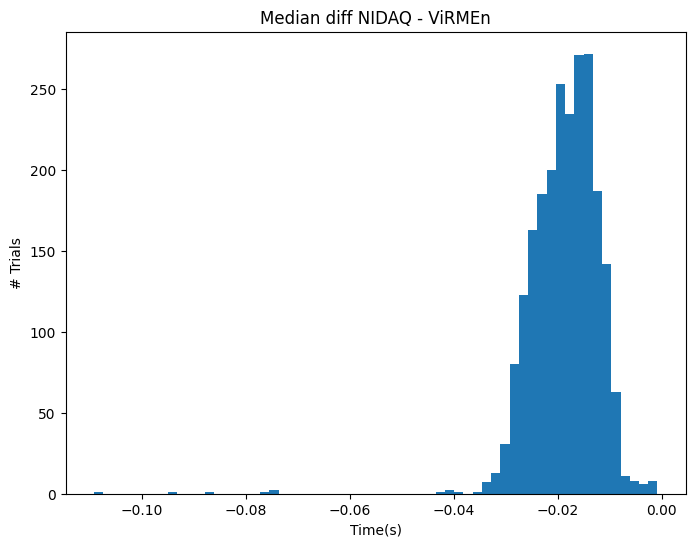

In [ ]:
plt.figure(figsize=(8, 6))

shift_stats = trial_sync_stats_df['median_diff'].copy()
num_0_shifts = (shift_stats == 0).sum()

num_shifts = shift_stats[shift_stats != 0]


plt.hist(num_shifts,bins=61)


plt.xlabel('Time(s)')
plt.ylabel('# Trials')
plt.title('Median diff NIDAQ - ViRMEn')

In [ ]:

trial_sync_stats_df['min_shift_abs'] = trial_sync_stats_df['min_shift'].abs()
trial_sync_stats_df['shift'] = trial_sync_stats_df[['max_shift', 'min_shift_abs']].max(axis=1)

trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift'] = trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift']*-1


Text(0.5, 1.0, '"Max" shift in trial to preserve median: 2184 trials without shift')

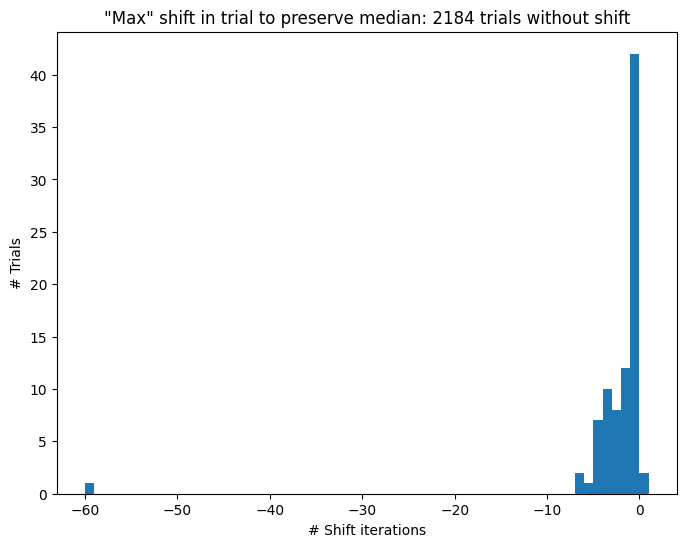

In [ ]:
plt.figure(figsize=(8, 6))

shift_stats = trial_sync_stats_df['shift'].copy()
num_0_shifts = (shift_stats == 0).sum()

num_shifts = shift_stats[shift_stats != 0]


plt.hist(num_shifts,bins=61)


plt.xlabel('# Shift iterations')
plt.ylabel('# Trials')
plt.title('"Max" shift in trial to preserve median: '+ str(num_0_shifts)+ ' trials without shift')

In [ ]:
def count_borrowed_iter(borrow_list):
    num_borrow = 0
    for i in range(len(borrow_list)):
        num_borrow = num_borrow+ borrow_list[i][1] - borrow_list[i][0] + 1

    return num_borrow


In [ ]:
trial_sync_stats_df['num_borrow_step2'] = trial_sync_stats_df['borrow_step2'].apply(count_borrowed_iter)
trial_sync_stats_df['num_borrow_step3'] = trial_sync_stats_df['borrow_step3'].apply(count_borrowed_iter)
trial_sync_stats_df['num_borrow_step4'] = trial_sync_stats_df['borrow_step4'].apply(count_borrowed_iter)


trial_sync_stats_df['total_borrow'] = trial_sync_stats_df['num_borrow_step2'] + trial_sync_stats_df['num_borrow_step3'] + trial_sync_stats_df['num_borrow_step4']  

trial_sync_stats_df['percentage_borrow'] = trial_sync_stats_df['total_borrow']*100 / trial_sync_stats_df['num_iterations']


Text(0.5, 1.0, 'Trial NIDAQ iterations borrowed from ViRMEn')

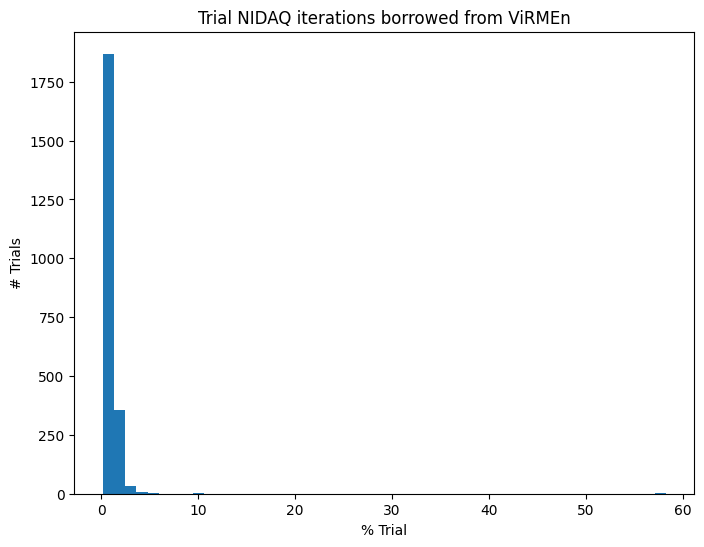

In [ ]:
plt.figure(figsize=(8, 6))



plt.hist(trial_sync_stats_df['percentage_borrow'],bins=50)


plt.xlabel('% Trial')
plt.ylabel('# Trials')
plt.title('Trial NIDAQ iterations borrowed from ViRMEn')

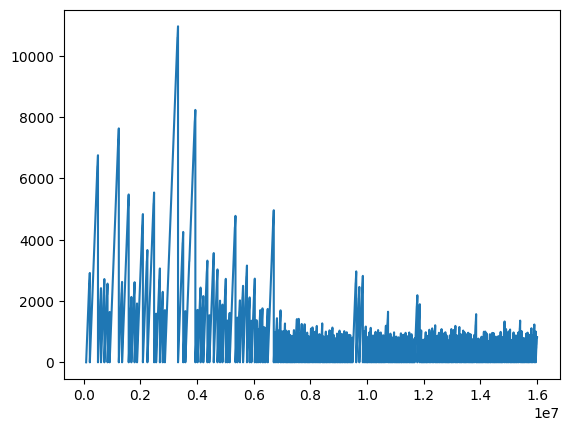

In [ ]:
plt.plot(iteration_dict['framenumber_vector_samples'])

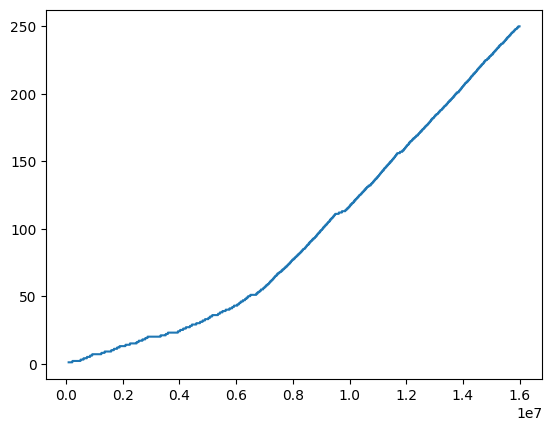

In [ ]:
plt.plot(iteration_dict['trialnumber_vector_samples'])